## Initial Steps for Working with GRIB Dataset in Python

### Step 1: Install Required Libraries
You will need pygrib, xarray, numpy, pandas, and matplotlib.
Use the following command to install them:
!pip install pygrib xarray numpy pandas matplotlib

In [20]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Step 2: Load and Explore the GRIB Data

In [21]:
# Load the GRIB dataset
data = xr.open_dataset('./data.grib', engine="cfgrib")

# Print available coordinates
print("Coordinates of the dataset:")
print(data.coords)

# Optionally, print specific coordinate values
print("\nLatitude values:")
print(data["latitude"].values)

print("\nLongitude values:")
print(data["longitude"].values)

# If the dataset has time:
if "time" in data.coords:
    print("\nTime values:")
    print(data["time"].values)
    
print(data.data_vars)

Can't read index file './data.grib.5b7b6.idx'
Traceback (most recent call last):
  File "/home/jonas/.local/lib/python3.10/site-packages/cfgrib/messages.py", line 550, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/jonas/.local/lib/python3.10/site-packages/cfgrib/messages.py", line 429, in from_indexpath
    index = pickle.load(file)
EOFError: Ran out of input
skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/home/jonas/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/jonas/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 639, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1136073600, 1136116800, 1136160000, ..., 1732622400, 1732665600,
       1732708800])) new_value=Vari

Coordinates of the dataset:
Coordinates:
    number               int64 8B ...
  * time                 (time) datetime64[ns] 102kB 2006-01-01 ... 2024-11-2...
    step                 timedelta64[ns] 8B ...
    surface              float64 8B ...
  * latitude             (latitude) float64 264B 44.0 43.75 43.5 ... 36.25 36.0
  * longitude            (longitude) float64 456B -10.0 -9.75 -9.5 ... 3.75 4.0
    valid_time           (time) datetime64[ns] 102kB ...
    depthBelowLandLayer  float64 8B ...

Latitude values:
[44.   43.75 43.5  43.25 43.   42.75 42.5  42.25 42.   41.75 41.5  41.25
 41.   40.75 40.5  40.25 40.   39.75 39.5  39.25 39.   38.75 38.5  38.25
 38.   37.75 37.5  37.25 37.   36.75 36.5  36.25 36.  ]

Longitude values:
[-10.    -9.75  -9.5   -9.25  -9.    -8.75  -8.5   -8.25  -8.    -7.75
  -7.5   -7.25  -7.    -6.75  -6.5   -6.25  -6.    -5.75  -5.5   -5.25
  -5.    -4.75  -4.5   -4.25  -4.    -3.75  -3.5   -3.25  -3.    -2.75
  -2.5   -2.25  -2.    -1.75  -1.5   -1.25 

## Generate labels for hot days

In [22]:
# Step 1: Restrict the dataset to May–August
data_summer = data.sel(time=data["time"].dt.month.isin([5, 6, 7, 8, 9]))

# Step 2: Extract temperature data (e.g., variable "t2m") for the summer months
temperature_summer = data_summer["t2m"]
# Step 3: Filter temperature measurements at 12:00 within summer months
# Step 3: Filter temperature measurements at 12:00 within summer months
temp_summer_12 = temperature_summer.sel(time=temperature_summer["time"].dt.hour == 12)

# Convert the time to "day" in datetime format with time set to 00:00:00
temp_summer_12 = temp_summer_12.assign_coords(day=temp_summer_12["time"].dt.floor("D"))

# Use "day" as the main dimension
temp_summer_12 = temp_summer_12.swap_dims({"time": "day"}).reset_coords("time", drop=True)

# Step 4: Extract July–August temperatures for percentile calculation
temp_july_aug = temp_summer_12.sel(day=temp_summer_12["day"].dt.month.isin([7, 8]))


# Step 5: Compute the 95th percentile for each location in July–August
percentile_95 = temp_july_aug.quantile(0.95, dim="day")

# Step 6: Label hot days (May–August) based on the 95th percentile
hot_days = temp_summer_12 > percentile_95

# Step 7: Add the "hot_day" label to the summer dataset
data_summer_labeled = data_summer.assign(hot_day=hot_days)

# Optional: Save the labeled dataset for further analysis
# data_summer_labeled.to_netcdf("labeled_summer_dataset.nc")

# Step 8: Verify the results
# print("Summer Dataset with Hot Day Labels:")
# print(data_summer_labeled.where(data_summer_labeled["hot_day"], drop=True))



## Aggregate all measurements of one day under one timestamp

In [23]:
data_summer_00 = data_summer.sel(time=data_summer["time"].dt.hour == 0)
data_summer_12 = data_summer.sel(time=data_summer["time"].dt.hour == 12)

data_summer_00 = data_summer_00.assign_coords(day=data_summer_00["time"].dt.floor("D"))
data_summer_12 = data_summer_12.assign_coords(day=data_summer_12["time"].dt.floor("D"))

data_summer_00 = data_summer_00.swap_dims({"time": "day"}).reset_coords("time", drop=True)
data_summer_12 = data_summer_12.swap_dims({"time": "day"}).reset_coords("time", drop=True)


# Rename variables in each dataset to include their time suffix
data_summer_00 = data_summer_00.rename({var: f"{var}_00" for var in data_summer_00.data_vars})
data_summer_12 = data_summer_12.rename({var: f"{var}_12" for var in data_summer_12.data_vars})
data_summer_00 = data_summer_00.drop_vars("valid_time", errors="ignore")
data_summer_12 = data_summer_12.drop_vars("valid_time", errors="ignore")

# Merge the renamed datasets
data_summer_merged = xr.merge([data_summer_00, data_summer_12])
# data_merged

In [24]:
# Recalculate the percentile with a lower threshold
percentile_95 = temp_july_aug.quantile(0.95, dim="day")
print("65th Percentile Temperature Values:")
print(percentile_95-273)

65th Percentile Temperature Values:
<xarray.DataArray 't2m' (latitude: 33, longitude: 57)> Size: 15kB
array([[20.33293457, 20.28775635, 20.31478271, ..., 30.69234619,
        32.3020874 , 34.19785156],
       [20.34399414, 20.30152588, 20.2145752 , ..., 33.10712891,
        33.90869141, 34.67664795],
       [20.18468018, 20.06081543, 19.94587402, ..., 30.93466797,
        29.3979126 , 29.1164917 ],
       ...,
       [22.67811279, 22.6168457 , 22.70465088, ..., 38.96369629,
        39.07728271, 39.13527832],
       [22.76929932, 22.83873291, 22.96600342, ..., 38.54870605,
        38.49307861, 38.82207031],
       [22.81617432, 22.9895752 , 23.14813232, ..., 38.93109131,
        39.0151001 , 39.23912354]])
Coordinates:
  * latitude   (latitude) float64 264B 44.0 43.75 43.5 43.25 ... 36.5 36.25 36.0
  * longitude  (longitude) float64 456B -10.0 -9.75 -9.5 -9.25 ... 3.5 3.75 4.0
    quantile   float64 8B 0.95


In [25]:
# Count the number of hot days (True values) in the "hot_day" field
num_hot_days = data_summer_labeled["hot_day"].sum().item()

print(f"Total number of hot days: {num_hot_days}")

# Count the number of hot days (True values) in the "hot_day" field
num_days = data_summer_labeled.dims["day"]
print(f"Total number of days: {num_days}")

# Sum the count of non-NaN values in "t2m" across time, latitude, and longitude
num_data_points = data_summer_labeled["t2m"].notnull().sum().item()
print(f"Total number of data points: {num_data_points}")



Total number of hot days: 139463
Total number of days: 2907


/tmp/ipykernel_16611/988324806.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_days = data_summer_labeled.dims["day"]


Total number of data points: 10936134


In [26]:
print("Temp Summer Dimensions:", temp_summer_12.shape)
print("Percentile 95 Shape:", percentile_95.shape)
print("Hot Days Shape:", hot_days.shape)

Temp Summer Dimensions: (2907, 33, 57)
Percentile 95 Shape: (33, 57)
Hot Days Shape: (2907, 33, 57)


## Calculating the number of 3 day streaks for each location to check if labeling is plausible

Distinct Three-Day Streaks per Location:
<xarray.DataArray 't2m' (latitude: 33, longitude: 57)> Size: 15kB
array([[ 9, 10,  9, ...,  9,  6,  9],
       [ 9,  8,  7, ...,  8,  8,  8],
       [ 8,  7,  6, ...,  7,  8,  9],
       ...,
       [12, 15, 15, ...,  7,  7,  6],
       [12, 13, 13, ...,  6,  7,  7],
       [15, 12, 13, ...,  7,  8,  6]])
Coordinates:
    number               int64 8B ...
    step                 timedelta64[ns] 8B ...
    surface              float64 8B ...
  * latitude             (latitude) float64 264B 44.0 43.75 43.5 ... 36.25 36.0
  * longitude            (longitude) float64 456B -10.0 -9.75 -9.5 ... 3.75 4.0
    depthBelowLandLayer  float64 8B ...
    quantile             float64 8B 0.95


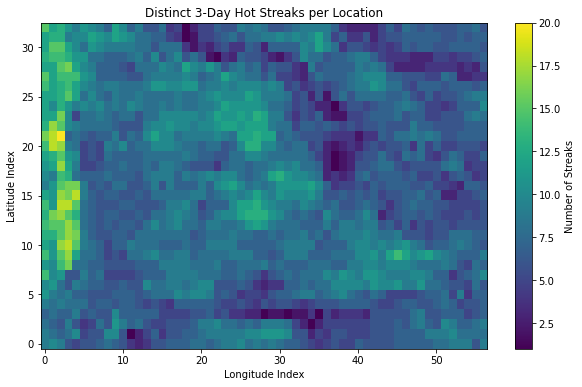

In [27]:
# deleting variables to free memory
del data, data_summer, temperature_summer, temp_summer_12, temp_july_aug, percentile_95, data_summer_labeled, data_summer_00, data_summer_12


# Step 1: Verify hot days array (already computed)
# print("Hot Days Array (Summary):")
# print(hot_days)

# Step 2: Apply a rolling window to compute streaks
streaks_rolling = (
    hot_days.rolling(day=3, center=False)   # Rolling 3-day window
    .construct("window_dim")                # Create a dimension for the rolling window
    .reduce(np.all, dim="window_dim")       # Check if all values in the window are True
)

# Step 3: Replace NaN values (from rolling) with 0
streaks_rolling_filled = streaks_rolling.fillna(0).astype(int)

# Verify rolling streaks
# print("Rolling Streaks (3-Day):")
# print(streaks_rolling_filled)

# Step 4: Count the number of streaks per location
def count_distinct_streaks(array):
    diff = np.diff(array, axis=0)
    streak_starts = (diff == 1).sum(axis=0)  # Count where a streak begins
    return streak_starts

distinct_streaks = xr.apply_ufunc(
    count_distinct_streaks,
    streaks_rolling_filled,
    input_core_dims=[["day"]],
    vectorize=True
)

# Step 5: Print results
print("Distinct Three-Day Streaks per Location:")
print(distinct_streaks)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Distinct 3-Day Hot Streaks per Location")
plt.imshow(distinct_streaks, origin="lower", aspect="auto")
plt.colorbar(label="Number of Streaks")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()


## Creating Target labels for each day (if the next 7 days contain at least 3 hot days)

In [28]:
# Define the rolling window size
window_size = 7

# Step 1: Restrict hot_days to May–July + first days of August
hot_days_limited = hot_days.sel(
    day=hot_days["day"].dt.month.isin([5, 6, 7]) |
         ((hot_days["day"].dt.month == 8) & (hot_days["day"].dt.day <= window_size))
)

# Count the number of hot days in each rolling window
hot_days_rolling = (
    hot_days.rolling(day=window_size, center=False)
    .construct("window_dim")
    .reduce(np.sum, dim="window_dim")
)

# Create labels: 1 if 3 or more hot days, 0 otherwise
labels_next_7_days = (hot_days_rolling >= 3).astype(int)

# Align the labels with the dataset (shift back by window_size - 1)
labels_next_7_days = labels_next_7_days.shift(day=-(window_size - 1))
# Does this makes sense?????

# Drop NaN values (caused by shifting)
labels_next_7_days = labels_next_7_days.dropna("day")

# Debug: Inspect the rolling sum
print("Rolling sum of hot days over 7-day window:")
print(hot_days_rolling)

# Debug: Inspect the labels before and after shifting
print("Labels before shifting (aligned with future interval):")
print((hot_days_rolling >= 3).astype(int))

print("Labels after shifting (aligned with current day):")
print(labels_next_7_days)

del hot_days, streaks_rolling, streaks_rolling_filled, distinct_streaks, hot_days_limited

Rolling sum of hot days over 7-day window:
<xarray.DataArray 't2m' (day: 2907, latitude: 33, longitude: 57)> Size: 44MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 0, ..., 0, 0, 0],
        [1,

In [29]:
from pympler import muppy, summary
# Filter global variables for numpy arrays and xarray datasets
arrays_and_datasets = {
    name: type(value).__name__
    for name, value in globals().items()
    if type(value).__name__ in ["ndarray", "Dataset", "DataArray"]
}

# Print the results
print(f"{'Variable':<20}{'Type':<20}")
print("=" * 40)
for name, var_type in arrays_and_datasets.items():
    print(f"{name:<20}{var_type:<20}")

# Collect all objects in memory
all_objects = muppy.get_objects()

# Summarize memory usage by type
summary.print_(summary.summarize(all_objects))

Variable            Type                
labels_next_7_days  DataArray           
years               ndarray             
yearly_data         Dataset             
rolling_chunk       Dataset             
yearly_labels       DataArray           
stacked_features    Dataset             
flattened_features  DataArray           
X                   ndarray             
flattened_labels    DataArray           
aligned_labels      DataArray           
y                   ndarray             
train_years         ndarray             
test_years          ndarray             
X_train             ndarray             
y_train             ndarray             
data_summer_merged  Dataset             
hot_days_rolling    DataArray           
                       types |   # objects |   total size
============================ | =========== | ============
               numpy.ndarray |         531 |    668.73 MB
                       tuple |      608130 |     59.01 MB
                        dict |

## Stacking data of 30 days onto each other and adding labels

In [30]:
print(data_summer_merged.coords)
#print("Rolling Chunk Days:")
#print(rolling_chunk["day"].values)

#print("\nLabels Next 7 Days:")
#print(labels_next_7_days["day"].values)


Coordinates:
    number               int64 8B 0
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
  * latitude             (latitude) float64 264B 44.0 43.75 43.5 ... 36.25 36.0
  * longitude            (longitude) float64 456B -10.0 -9.75 -9.5 ... 3.75 4.0
    depthBelowLandLayer  float64 8B 0.0
  * day                  (day) datetime64[ns] 23kB 2006-05-01 ... 2024-09-30


In [40]:
import torch
# Extract unique years from the 'day' coordinate
years = np.unique(data_summer_merged["day"].dt.year)
feature_window_size = 30

# Directory for saving temporary results
processed_dir = "temp_features_by_year"
os.makedirs(processed_dir, exist_ok=True)

for year in years:
    # Select data for the current year
    yearly_data = data_summer_merged.sel(
            day=(data_summer_merged["day"].dt.year == year) &
                 (data_summer_merged["day"].dt.month.isin([5, 6, 7, 8]))
    )
    # Create rolling windows
    rolling_chunk = (
        yearly_data.rolling(day=feature_window_size, center=False)
        .construct("feature_dim")
        .dropna("day")
    )
    
    # Align features with labels
    yearly_labels = labels_next_7_days.sel(day=rolling_chunk["day"])
    rolling_chunk, yearly_labels = xr.align(rolling_chunk, yearly_labels, join="inner")
    
    
    stacked_features = rolling_chunk.stack(location=("latitude", "longitude"))
    flattened_features = stacked_features.to_array(dim="variables").stack(features=("variables", "feature_dim")).transpose("day", "location", "features")
    X = flattened_features.values.reshape(flattened_features.shape[0] * flattened_features.shape[1], -1)

    # Check the resulting shape
    #stacked_labels = yearly_labels.stack(location=("latitude", "longitude"))
    #flattened_labels = stacked_labels.to_array(dim="variables").stack(features=("variables", "feature_dim")).transpose("day", "location", "features")
    #aligned_labels = flattened_labels.sel(day=stacked_features["day"])
    #y = aligned_labels.values.flatten()  # Flatten into a single column
    
    stacked_labels = yearly_labels.stack(location=("latitude", "longitude"))
    y = stacked_labels.values.flatten()  # Flatten into a single column

    # Save to disk
    torch.save(torch.tensor(X, dtype=torch.float32), f"{processed_dir}/features_{year}.pt")
    torch.save(torch.tensor(y, dtype=torch.float32), f"{processed_dir}/labels_{year}.pt")
    
print("Shape of flattened features (X_train):", X.shape)
print("Shape of flattened labels (y_train):", y.shape)

#del data_summer_merged, hot_days_rolling

Shape of flattened features (X_train): (176814, 420)
Shape of flattened labels (y_train): (176814,)


In [41]:
import dask
print(dask.__version__)


2024.12.1


## Train/Test split and flattening the arrays so they can be processed by NN
The final array will be 2D. Each record corresponds with one location and one day. This record contains the data of the previous 30 days

In [54]:
years = np.linspace(2006,2024,24-6+1).astype(int)
train_years = years[years < 2022]
test_years = years[years >= 2022]
processed_dir = "temp_features_by_year"

# Load and train incrementally
def load_data_for_year(year):
    X = torch.load(f"{processed_dir}/features_{year}.pt")
    y = torch.load(f"{processed_dir}/labels_{year}.pt")    
    return X, y

# Initialize DataLoader for incremental training
batch_size = 32

In [62]:
X_train, y_train = load_data_for_year(2020)
print(X_train.shape[1])
print(y_train.shape)


420
torch.Size([176814])


In [71]:
years = np.linspace(2006,2024,24-6+1).astype(int)
train_years = years[years < 2022]
test_years = years[years >= 2022]

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# Train the model
class HotDayPredictor(nn.Module):
    def __init__(self, input_size):
        super(HotDayPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

input_size = X_train.shape[1]  # Replace with your feature size
model = HotDayPredictor(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

global_sum = 0.0
global_sq_sum = 0.0
global_count = 0

# Calculate global statistics from all training years
for year in train_years:
    X_train, _ = load_data_for_year(year)
    global_sum += X_train.sum(dim=0)
    global_sq_sum += (X_train ** 2).sum(dim=0)
    global_count += X_train.size(0)
global_mean = global_sum / global_count
global_std = torch.sqrt((global_sq_sum / global_count) - (global_mean ** 2))

train_losses = []
val_losses = []
for epoch in range(5):  # Adjust the number of epochs
    print(f"Epoch {epoch + 1}")
    total_train_loss = 0.0
    for year in train_years:
        X_train, y_train = load_data_for_year(year)
        
        # Normalize features using global statistics
        X_train = (X_train - global_mean) / global_std
        
        # Create DataLoader
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Train the model
        year_loss = 0.0
        for batch in dataloader:
            features, labels = batch
            optimizer.zero_grad()
            predictions = model(features).squeeze()
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            year_loss += loss.item()

        year_avg_loss = year_loss / len(dataloader)
        print(f"Year {year} - Loss: {year_avg_loss:.6f}")
    
        # Add the yearly loss to the total training loss
        total_train_loss += year_avg_loss
        
    epoch_train_loss = total_train_loss / len(train_years)
    train_losses.append(epoch_train_loss)
    print(f"Training Loss: {epoch_train_loss:.6f}")

    # Validation Loop
    total_val_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for year in test_years:  # Validation on test data
            X_val, y_val = load_data_for_year(year)
            X_val = (X_val - global_mean) / global_std            
            predictions = model(X_val).squeeze()
            val_loss = loss_fn(predictions, y_val)
            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(test_years)
    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss:.6f}")
    model.train()  # Reset the model to training mode


Epoch 1
Year 2006 - Loss: 0.042182
Year 2007 - Loss: 0.011006
Year 2008 - Loss: 0.000694
Year 2009 - Loss: 0.010260
Year 2010 - Loss: 0.022622
Year 2011 - Loss: 0.002161
Year 2012 - Loss: 0.047179
Year 2013 - Loss: 0.022012
Year 2014 - Loss: 0.005306
Year 2015 - Loss: 0.055504
Year 2016 - Loss: 0.026459
Year 2017 - Loss: 0.045190
Year 2018 - Loss: 0.036489
Year 2019 - Loss: 0.028467
Year 2020 - Loss: 0.043824
Year 2021 - Loss: 0.022101
Training Loss: 0.026341
Validation Loss: 1.431667
Epoch 2
Year 2006 - Loss: 0.037708
Year 2007 - Loss: 0.009077
Year 2008 - Loss: 0.002220
Year 2009 - Loss: 0.009643
Year 2010 - Loss: 0.020957
Year 2011 - Loss: 0.001919
Year 2012 - Loss: 0.045214
Year 2013 - Loss: 0.020414
Year 2014 - Loss: 0.005420
Year 2015 - Loss: 0.051658
Year 2016 - Loss: 0.027738
Year 2017 - Loss: 0.043374
Year 2018 - Loss: 0.033775
Year 2019 - Loss: 0.025168
Year 2020 - Loss: 0.042829
Year 2021 - Loss: 0.019769
Training Loss: 0.024805
Validation Loss: 1.863266
Epoch 3
Year 2006 - 

In [72]:
print(len(train_losses))
print(len(val_losses))

5
5


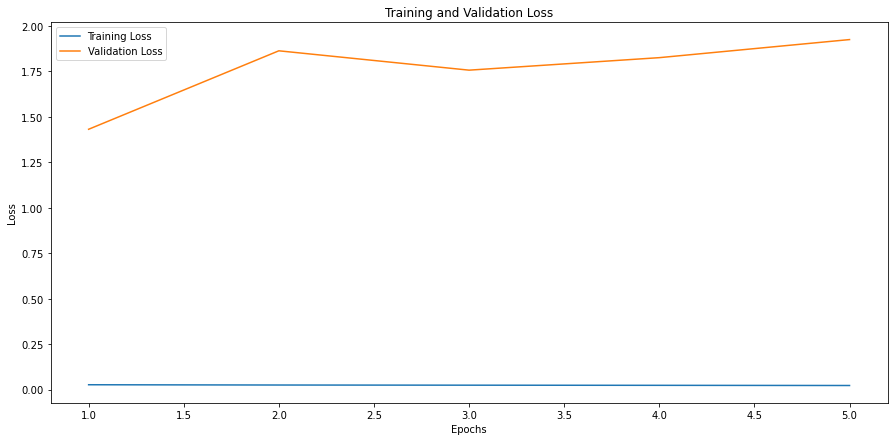

In [75]:
# Plot Loss Curves
plt.figure(figsize=(15, 7))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Save the plot as a high-resolution PNG
plt.savefig("training_validation_loss_baseline.png", dpi=300, bbox_inches="tight")  # 300 DPI for high resolution

# Show the plot
plt.show()

### Using different NN and other models to train and test

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Evaluate on test data
model.eval()
all_predictions = []
all_labels = []

for year in test_years:
    X_test, y_test = load_data_for_year(year)
    
    # Convert to PyTorch tensors
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Normalize features
    X_test = (X_test - X_test.mean(dim=0)) / X_test.std(dim=0)

    # Predict
    with torch.no_grad():
        predictions = model(X_test).squeeze()
        all_predictions.append((predictions > 0.5).float().numpy())
        all_labels.append(y_test.numpy())

# Combine results and evaluate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
positive_rate = torch.sum(y_train == 1).item() / y_train.size(0)
print(f"Positive rate: {positive_rate}")

In [ ]:
# Define a dataset and data loader
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the model
class HotDayPredictor(nn.Module):
    def __init__(self, input_size):
        super(HotDayPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Initialize the model
input_size = X_train.shape[1]
model = HotDayPredictor(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Train the model
for epoch in range(30):
    for batch in dataloader:
        features, labels = batch
        predictions = model(features)
        loss = loss_fn(predictions.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_features and test_labels are prepared as PyTorch tensors
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predicted_classes = (predictions > 0.5).float()  # Convert probabilities to binary classes

# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_classes.numpy())
precision = precision_score(y_test.numpy(), predicted_classes.numpy())
recall = recall_score(y_test.numpy(), predicted_classes.numpy())
f1 = f1_score(y_test.numpy(), predicted_classes.numpy())
print("Initial NN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
# Define the model
class DeeperHotDayPredictor(nn.Module):
    def __init__(self, input_size):
        super(DeeperHotDayPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)


# Initialize the model
input_size = X_train.shape[1]
model = DeeperHotDayPredictor(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Train the model
for epoch in range(30):
    for batch in dataloader:
        features, labels = batch
        predictions = model(features)
        loss = loss_fn(predictions.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_features and test_labels are prepared as PyTorch tensors
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predicted_classes = (predictions > 0.5).float()  # Convert probabilities to binary classes

# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_classes.numpy())
precision = precision_score(y_test.numpy(), predicted_classes.numpy())
recall = recall_score(y_test.numpy(), predicted_classes.numpy())
f1 = f1_score(y_test.numpy(), predicted_classes.numpy())
print("Deeper NN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
# Define the model
class DropoutHotDayPredictor(nn.Module):
    def __init__(self, input_size):
        super(DropoutHotDayPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)


# Initialize the model
input_size = X_train.shape[1]
model = DropoutHotDayPredictor(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Train the model
for epoch in range(30):
    for batch in dataloader:
        features, labels = batch
        predictions = model(features)
        loss = loss_fn(predictions.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_features and test_labels are prepared as PyTorch tensors
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predicted_classes = (predictions > 0.5).float()  # Convert probabilities to binary classes

# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_classes.numpy())
precision = precision_score(y_test.numpy(), predicted_classes.numpy())
recall = recall_score(y_test.numpy(), predicted_classes.numpy())
f1 = f1_score(y_test.numpy(), predicted_classes.numpy())
print("Dropout NN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

# Assuming test_features and test_labels are prepared as PyTorch tensors
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
predicted_classes = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

print("Random Forest")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
print(data.data_vars)